In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# parameters
lambda_ = 0.03 # hazard rate
recovery_rate = 0.00 #recovery rate
N = 1000000 # nominal value of the contract
K = 0.0039 # fixed rate
T = 5 # the time of the contract years

# dt = 0.25 #delta t
# T = np.array([0, 0.25, 0.5, 0.75, 1]) # time
# S = np.array([0.0004, 0.0025, 0.0032, 0.004]) # spot rate

In [3]:
data = pd.read_csv('OIS_simulate_1000_lines.csv')
data.drop(columns = 'Unnamed: 0', inplace = True, axis = 1)
data.head()

,0.0833,0.1667,0.25,0.3333,0.4167,0.5,0.5833,0.6667,0.75,0.8333,...,4.25,4.3333,4.4167,4.5,4.5833,4.6667,4.75,4.8333,4.9167,5.0
0,0.007694,0.007588,0.007492,0.007403,0.007322,0.007248,0.007182,0.007121,0.007066,0.007017,...,0.006965,0.006979,0.006992,0.007006,0.007019,0.007033,0.007046,0.007059,0.007072,0.007085
1,0.007135,0.006961,0.006801,0.006652,0.006515,0.006389,0.006273,0.006166,0.006068,0.005977,...,0.005363,0.005374,0.005386,0.005397,0.005409,0.005421,0.005433,0.005445,0.005457,0.005469
2,0.006613,0.006533,0.006460,0.006394,0.006334,0.006280,0.006231,0.006187,0.006148,0.006113,...,0.006209,0.006222,0.006235,0.006248,0.006260,0.006273,0.006286,0.006298,0.006311,0.006323
3,0.008007,0.007887,0.007776,0.007672,0.007576,0.007487,0.007404,0.007327,0.007256,0.007190,...,0.006563,0.006567,0.006571,0.006575,0.006579,0.006583,0.006588,0.006592,0.006597,0.006601
4,0.006280,0.006208,0.006144,0.006087,0.006035,0.005990,0.005950,0.005916,0.005886,0.005860,...,0.006262,0.006280,0.006298,0.006315,0.006333,0.006350,0.006368,0.006385,0.006402,0.006418


In [4]:
num_periods = len(data.columns)
dt = T/num_periods
T_series = dt*np.array([i for i in range(0,num_periods+1)])
                               

# Utility function for CVA calculation

In [5]:
def cal_discount_factor(spot_rate, time):
  
  '''calculate discount factor from sequence of spot rate'''
  return np.exp(-spot_rate*time)

def cal_forward(spot_rate, time):
  '''calculate forward rate from spot rate'''
  
  forward_list = []
  forward_list.append(spot_rate[0])
  for i in range(1,len(spot_rate)):
    forward_list.append((spot_rate[i]*time[i] - spot_rate[i-1]*time[i-1])/(time[i]-time[i-1]))
  
  return np.array(forward_list)

def cal_default_prob(t_prev, t_next, hazard = lambda_):
  '''calculate the default probability'''
  
  dp_list = np.exp(-hazard*t_prev) - np.exp(-hazard*t_next)
  return dp_list

def mark_to_market(discount_list, forward_list):
  '''calculate mark-to-market value'''
  
  mtm_sublist = N*dt*discount_list*(forward_list-K)
  mtm_list = mtm_sublist[::-1].cumsum()[::-1]
  mtm_list = np.concatenate((mtm_list, [0]))
  return mtm_list

def compute_exposure(mtm_value):
  '''calculate exposure from the sequene of MTM value'''
  
  return np.maximum(mtm_value,0)

def cal_cva(exposure_list, discount_list, dp_list):
  
  '''calculate CVA with input the exposure_list, the discount factor list df_list
  and the default probability dp_list'''
  cva = (1-recovery_rate)*((np.roll(exposure_list,1)[1:]+exposure_list[1:])/2)\
        *((np.roll(discount_list,1)+discount_list)/2)*dp_list
  return cva.sum()
      
def combine_cva(df, hzd = lambda_):
  dp_list = cal_default_prob(T_series[:-1], T_series[1:], hazard = hzd)
  discount_list_baseline = cal_discount_factor(data.iloc[0].astype(float), T_series[1:])
  exposure_list_arr = []
  mtm_list_arr = []
  for _, row in df.iterrows():
    spot_rate = row.values.astype(float)
    discount_list = cal_discount_factor(spot_rate, T_series[1:])
    forward_list = cal_forward(spot_rate, T_series[1:])
    mtm_list = mark_to_market(discount_list, forward_list)
    exposure_list = compute_exposure(mtm_list)
    exposure_list_arr.append(exposure_list)
    mtm_list_arr.append(mtm_list)
  exposure_df = pd.DataFrame(exposure_list_arr)
  mtm_df = pd.DataFrame(mtm_list_arr)
  exposure_ave = exposure_df.mean().values.astype(float)
  final_cva = cal_cva(exposure_ave, discount_list_baseline, dp_list)
  return final_cva, exposure_ave, mtm_df      

# Calculate CVA with initial $\lambda$

In [6]:
final_cva, exposure_ave, mtm_df = combine_cva(data)

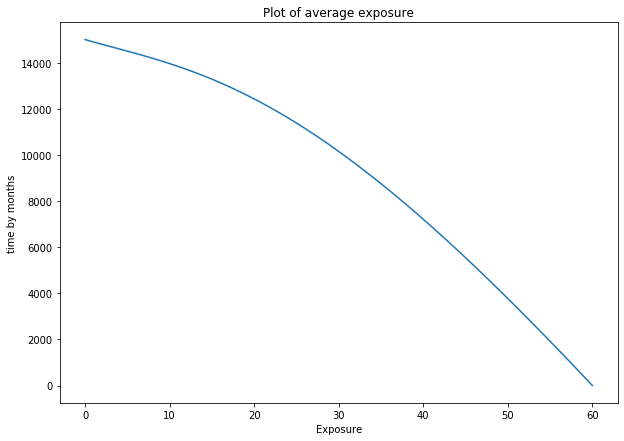

In [7]:
# Plot of average exposure with time
plt.figure(figsize = (10,7))
plt.plot(exposure_ave)
plt.title('Plot of average exposure')
plt.xlabel('Exposure')
plt.ylabel('time by months')
plt.show()

In [17]:
mtm_df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,15634.607520,15318.619173,15020.456254,14737.838180,14468.732188,14211.320260,13963.844792,13724.813766,13492.892730,13266.743878,...,2806.879523,2502.307592,2195.676638,1887.198897,1576.879881,1264.719460,950.932847,635.518173,318.468584,0.0
1,7733.400340,7464.001139,7223.657336,7009.031639,6817.145861,6645.333620,6490.982068,6351.883353,6226.060412,6111.483091,...,1587.339080,1420.348472,1250.771024,1078.806089,904.476722,727.798213,548.978565,368.032798,184.968867,0.0
2,11912.813904,11686.824745,11474.302342,11273.421939,11082.557746,10900.256231,10725.120623,10555.962525,10391.719440,10231.338009,...,2236.896755,1994.865367,1750.993593,1505.480479,1258.326094,1009.525839,759.280189,507.582620,254.422522,0.0
3,13284.535509,12942.515791,12620.658807,12316.809578,12029.043150,11755.634715,11494.879588,11245.341405,11005.733060,10774.713383,...,2122.539285,1891.453855,1659.067508,1425.460143,1190.653612,954.665009,717.581428,479.420684,240.196188,0.0
4,12372.276655,12174.041059,11987.848064,11811.829101,11644.321456,11483.840210,11328.977931,11178.531422,11031.426189,10886.623799,...,2479.790568,2212.099436,1942.174281,1670.282325,1396.414868,1120.558122,842.978485,563.658960,282.578209,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,19717.915044,19600.717026,19477.421701,19347.386880,19210.054385,19064.936170,18911.686470,18749.975871,18579.518357,18400.199211,...,4092.555393,3646.630360,3198.078746,2747.364630,2294.433858,1839.228815,1382.199541,923.279938,462.401530,0.0
996,13635.431100,13604.522394,13572.695340,13538.653903,13501.255972,13459.490229,13412.502495,13359.531466,13299.904017,13233.114625,...,3335.935390,2976.763728,2614.230819,2248.858394,1880.593905,1509.379710,1135.724694,759.562384,380.822474,0.0
997,16478.829793,16351.054252,16229.966653,16113.486977,15999.772498,15887.183865,15774.242812,15659.663173,15542.301294,15421.156853,...,3783.006777,3375.642984,2964.514170,2550.161144,2132.541521,1711.606157,1287.885861,861.323055,431.854774,0.0
998,16207.042202,16108.418266,16011.631654,15915.149881,15817.619131,15717.838034,15614.758665,15507.458349,15395.119110,15277.076435,...,3679.006917,3281.723464,2881.081503,2477.591891,2071.207660,1661.876329,1250.097306,835.809698,418.948363,0.0


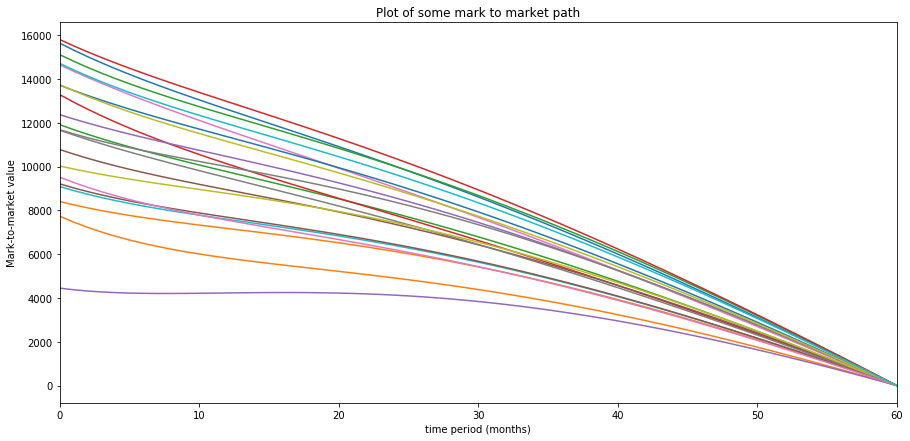

In [8]:
#plot of some MTM path
plt.figure(figsize = (15,7))
for i in range(20):
  mtm = mtm_df.iloc[i]
  mtm.plot()
plt.title('Plot of some mark to market path')  
plt.ylabel('Mark-to-market value')
plt.xlabel('time period (months)')
plt.show()  

#Sensitivity analysis of CVA with respect to $\lambda$

In [9]:
lmbd_list =  [0.03*i for i in range(1,10)] # change value of lambda
cva_lmbd_sensitive = []
for lmbd_ in lmbd_list:
  cva, _, _ = combine_cva(data, hzd = lmbd_)
  cva_lmbd_sensitive.append(cva)

In [10]:
sensitivity_df = pd.DataFrame(list(zip(lmbd_list, cva_lmbd_sensitive)), columns = ['lambda', 'CVA'])

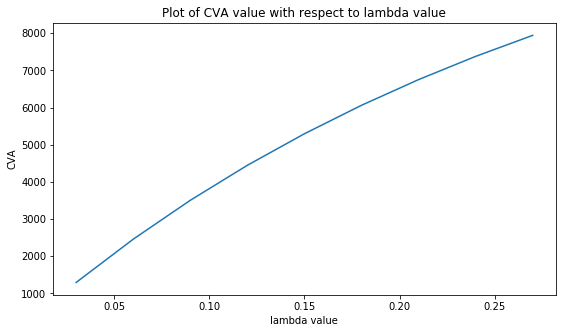

In [11]:
plt.figure(figsize = (9,5))
plt.plot(sensitivity_df['lambda'], sensitivity_df['CVA'])
plt.xlabel('lambda value')
plt.ylabel('CVA')
plt.title('Plot of CVA value with respect to lambda value')
plt.show()